In [502]:
using CSV, DataFrames, Distributions,StatsBase, PythonPlot,Random
using AbstractGPs, Stheno
using GaussianProcesses
using SavitzkyGolay
#GaussianProcesses

include("processing_functions.jl")

#NSF_CAREER_PATH = "/Users/elevien/Dartmouth College Dropbox/Ethan Levien/PROPOSALS/NSFCareer2024/figures/growth_dynamics"
FIG_PATH = "./../../figures"

"./../../figures"

# Load data and preprocessing

In [506]:
df_all = CSV.read("./output/data_processed.csv",DataFrames.DataFrame);
df_all = df_all[df_all.cellcycle .== "i",:]
lineages = unique(df_all.lineage);

function linreg(t,y)
    X = hcat(ones(length(t)),t)
    b = X \y
    return y .- X*b
end

function standardize(x)
    return (x .- mean(x)) ./ std(x)
end

function fit_scale(t,x)
    standardize(linreg(t,x))
end

df_all = combine(groupby(df_all,:lineage),[:time,:lnM_sum]=>fit_scale=>:z,
:age,:age_normed,:time,:lnM,:gr,:gr_dt,:position,:lnM_sum);




In [ ]:
# make a figure showing some of the lineages after subtracting the lineage trend
fig,ax = subplots(figsize=(10,2))

for k in 1:length(lineages)
    dfl = df_all[df_all.lineage .== lineages[k],:]
    for p in unique(dfl.position)
        dflp = dfl[dfl.position .==p,:]
        ax.plot(dflp.time ,dflp.z,"C"*string(k)*"-",lw=0.5)
    
    end
    
    
    # ax.set_ylim([-6,6]) 
end
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.set_xlabel("time [hours]")
ax.set_ylabel(L"$f$ - (linear trend)")
savefig(FIG_PATH*"/traces_detrended.pdf",bbox_inches="tight")

fig

In [ ]:
# make a figure showing some of the lineages after subtracting the lineage trend
fig,ax = subplots(figsize=(10,2))

for k in 1:length(lineages)
    dfl = df_all[df_all.lineage .== lineages[k],:]
    for p in unique(dfl.position)
        dflp = dfl[dfl.position .==p,:]
        ax.plot(dflp.time ,dflp.z,"C"*string(k)*"-",lw=0.5)
    
    end
    
    
    # ax.set_ylim([-6,6]) 
end
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.set_xlabel("time [hours]")
ax.set_ylabel(L"$f$ - (linear trend)")
savefig(FIG_PATH*"/traces_detrended.pdf",bbox_inches="tight")

fig

## Smoothing and removing age dependence

In [512]:
# fig,ax = subplots(figsize=(10,1))
# df1 = df_all[df_all.lineage .== lineages[1],:]

# #df1 = df1[df1.position .< 3,:]
# sg = savitzky_golay(df1.z, 51,3,deriv=1,rate=mean(diff(df.time)))
# #ax.plot(df1.time,df1.z,lw=0.8)
# ax.plot(df1.time,sg.y,lw=0.9)
# fig

In [513]:
function growth_decomposition_pipeline(df,smoother)
    """
    This function does the following
        1. smooths the fluctuations in cummulative log mass using smoother
        2. differentiates the smoothed data to get the growth rates
        3. decomposes the growth rates into a fluctuaton component and trend by subtracting the trend
    """
    dfs = []
    for df1 in groupby(df,:lineage)
        df_smoothed = combine(groupby(df1,:position),[:time,:z]=>smoother=>AsTable,names(df_all))
        sort!(df_smoothed,:time)
        df_smoothed[:,:age_rounded] = round.(df_smoothed.age_normed,digits=2)
        df_smoothed= combine(groupby(df_smoothed,:age_rounded),:dm=>mean=>:dm_trend,names(df_smoothed),:dm=>var=>:dm_var,names(df_smoothed));
        df_smoothed[:,:dm_flucs] = df_smoothed[:,:dm] .- df_smoothed[:,:dm_trend] ;
        push!(dfs,df_smoothed)
    end
    df_smoothed =  vcat(dfs...);
    return df_smoothed
end




growth_decomposition_pipeline (generic function with 1 method)

In [598]:
mZero = GaussianProcesses.MeanZero() 
kern = SE(-0.0,0.0)  
logObsNoise = -5.0
function gp_smooth(t,u)
    gp = GaussianProcesses.GP(t,u,mZero,kern,logObsNoise)
    m, s = predict_y(gp,t)
    dm = diff(m)
    push!(dm,dm[end])
    dm = (dm .- mean(dm)) ./std(dm)
    return (m=m,dm=dm,s=s)
end


gp_smooth (generic function with 2 methods)

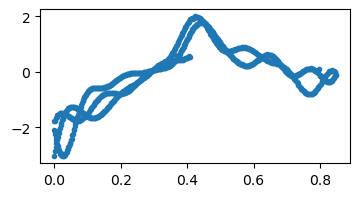

In [613]:
df1 = df_all[df_all.lineage .== lineages[2],:]
df1_smoothed = combine(groupby(df1,:position),[:time,:z]=>gp_smooth=>AsTable,names(df_all));
fig, ax= subplots(figsize=(4,2))
max_ind = 1000
ax.plot(df1_smoothed.age[1:max_ind],df1_smoothed.dm[1:max_ind],".")
fig

In [514]:

df_all_smoothed = growth_decomposition_pipeline(df_all,gp_smooth);




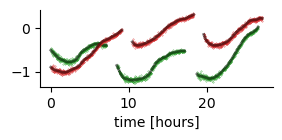

In [582]:
fig,ax = subplots(figsize=(3,1))
for j in [2,3]
    df1 = df_all_smoothed[df_all_smoothed.lineage .==lineages[j],:]
    t0 = df1.time[1]
    for k in 1:3
        dfp = df1[df1.position .== unique(df1.position)[k],:]
        ax.plot(dfp.time .-t0,dfp.z,".",color="C"*string(j),lw=0.4,markersize=0.5)
        ax.plot(dfp.time .-t0,dfp.m,"k-",lw=2,alpha=0.5)
        
    end
end
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.set_xlabel("time [hours]")
savefig(FIG_PATH*"/smoothing.pdf",bbox_inches="tight")

fig

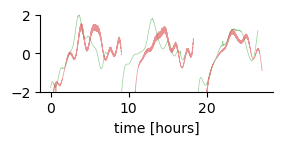

In [596]:
fig,ax = subplots(figsize=(3,1))
for j in [2,3]
    df1 = df_all_smoothed[df_all_smoothed.lineage .==lineages[j],:]
    t0 = df1.time[1]
    for k in 1:3
        dfp = df1[df1.position .== unique(df1.position)[k],:]
        ax.plot(dfp.time .-t0,dfp.dm,"-",color="C"*string(j),lw=0.5,alpha=0.5)
        
    end
end
ax.set_ylim([-2,2])
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.set_xlabel("time [hours]")
savefig(FIG_PATH*"/diff.pdf",bbox_inches="tight")
fig

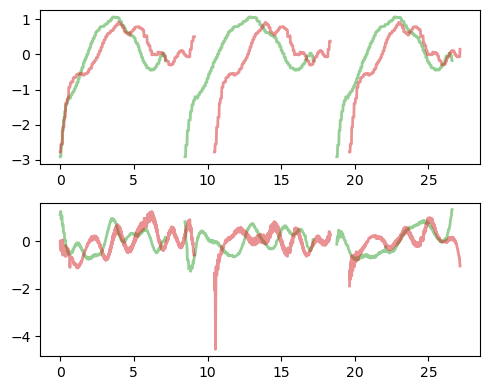

In [595]:
fig,axs = subplots(figsize=(5,4),nrows=2)
for j in [2,3]
    df1 = df_all_smoothed[df_all_smoothed.lineage .==lineages[j],:]
    t0 = df1.time[1]
    for k in 1:3
        dfp = df1[df1.position .== unique(df1.position)[k],:]
        axs[0].plot(dfp.time .-t0,dfp.dm_trend,"-",color="C"*string(j),lw=2,alpha=0.5)
        axs[1].plot(dfp.time .-t0,dfp.dm_flucs,"-",color="C"*string(j),lw=2,alpha=0.5)
        
    end
end
ax.set_ylim([-2,2])
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.set_xlabel("time [hours]")
tight_layout()
savefig(FIG_PATH*"/decomp.pdf",bbox_inches="tight")
fig

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


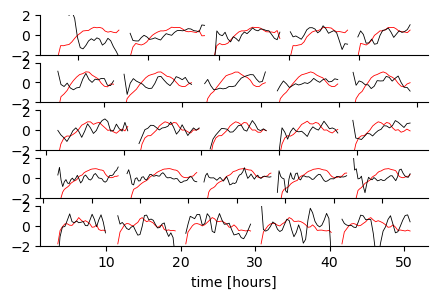

In [510]:

L = 5
fig, axs= subplots(figsize=(5,3),nrows=length(lineages[1:L]))
for j in 1:length(lineages[1:L])
    ax = axs[j-1]
    df1 = df_all_smoothed[df_all_smoothed.lineage .==lineages[j],:]

    for k in 1:5
        df = df1[df1.position .== unique(df1.position)[k],:]
        ax.plot(df.time[1:20:end],df.dm_trend[1:20:end],"r-",lw=0.6)
        ax.plot(df.time[1:20:end],df.dm_flucs[1:20:end],"k-",lw=0.6)
    end
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
    #ax.tick_params(axis="both", left=false, top=false, right=false, bottom=false, labelleft=false, labeltop=false, labelright=false, labelbottom=false)
    ax.set_ylim([-2,2])
end
axs[L-1].legend(frameon=false)
axs[L-1].set_xlabel("time [hours]")
savefig(FIG_PATH*"/decomp.pdf",bbox_inches="tight")

fig

In [349]:
@doc smooth

No documentation found.

Binding `smooth` does not exist.


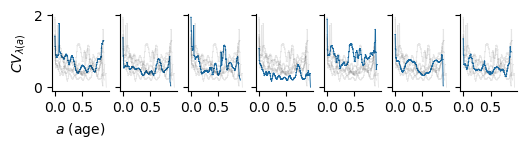

In [499]:

fig, axs = subplots(figsize=(6,1),ncols=length(lineages),sharey=true)

for k in 1:length(lineages)
    ax = axs[k-1]
    df1 = df_all_smoothed[df_all_smoothed.lineage .== lineages[k],:]

    CV = sqrt.(df1.dm_var)
    ax.plot(df1.age_normed,CV ,"-",lw=0.6)
    for ax in axs
        ax.plot(df1.age_normed,CV ,"k-",lw=0.6,alpha=0.1)
    end
    
   #ax.set_ylim([0,1.4])
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
    
end

axs[0].set_ylabel(L"$CV_{\lambda(a)}$")
axs[0].set_xlabel(L"$a$ (age)")
fig

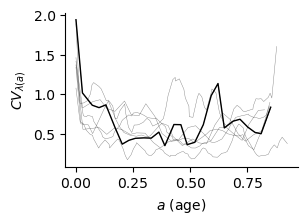

In [511]:

fig, ax = subplots(figsize=(3,2),sharey=true)



df1 = df_all_smoothed[df_all_smoothed.lineage .== lineages[3],:]

CV = sqrt.(df1.dm_var)
ax.plot(df1.age_normed[1:200:end],CV[1:200:end] ,"k-",lw=1.)

for k in 1:length(lineages)
    df1 = df_all_smoothed[df_all_smoothed.lineage .== lineages[k],:]

    CV = sqrt.(df1.dm_var)
    ax.plot(df1.age_normed[1:200:end],CV[1:200:end] ,"k-",lw=0.3,alpha=0.5)
end
#ax.set_ylim([0,1.4])
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
    


ax.set_ylabel(L"$CV_{\lambda(a)}$")
ax.set_xlabel(L"$a$ (age)")
savefig(FIG_PATH*"/CV.pdf",bbox_inches="tight")
fig


In [ ]:
msds = [mean([(x[i]-x[i+k])^2 for i in 1:(length(t)-k)]) for k in 1:200];

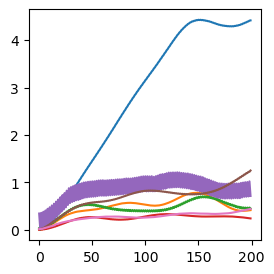

In [403]:

fig,ax = subplots(figsize=(3,3))

for j in 1:length(lineages)
    df1 = sort!(df_all_smoothed[df_all_smoothed.lineage .==lineages[j],:],:time);
    df1 = df1[df1.position .==1,:]
    t,x = df1.time,df1[:,:dm_flucs]
    k=5
    msds = [mean([(x[i]-x[i+k])^2 for i in 1:(length(t)-k)]) for k in 1:200];
    ax.plot(msds,"-")
end
fig


In [277]:
sm/k

0.9461047921536944

In [296]:
function MSD_within(df,lag,label)
    t,x,positions= df.time,df[:,label],df[:,:position]
    S = 0.
    for p in positions
        dfp = df[df.position .== p,:]
        sm = 0.
        ϵ = 2
        k = 0
        for i in 1:length(t)
            j = 1
            while (abs(t[j]-t[j])<lag) && j<length(t)
                j = j+1
            end
            sm = sm .+ (x[i]-x[j])^2
            k = k + 1
        end
        S = S + sm/k
    end
    S = S/length(positions)
    return S
end

MSD_within (generic function with 1 method)

In [297]:
msds = [MSD_within(df1,i,:dm_flucs) for i in 1:10]

InterruptException: InterruptException: